In [12]:
!pip install nltk

  Using cached https://files.pythonhosted.org/packages/f6/1d/d925cfb4f324ede997f6d47bea4d9babba51b49e87a767c170b77005889d/nltk-3.4.5.zip
  Created wheel for nltk: filename=nltk-3.4.5-cp37-none-any.whl size=1449909 sha256=b5cae9d52ec9d2be0c49b2ec64906b6fa43de662c3e4a16631a504a13ed6704c
  Stored in directory: /Users/sathvik/Library/Caches/pip/wheels/96/86/f6/68ab24c23f207c0077381a5e3904b2815136b879538a24b483
Successfully built nltk


In [13]:
import nltk
import numpy as np

In [23]:
nltk.download('semcor')

[nltk_data] Downloading package semcor to /Users/sathvik/nltk_data...


True

## Preprocessing

We first need to get tagged senses for words from SEMCOR, so we build some utils on top of the NLTK corpus reader. For this EDA, we're going to run BERT on instances of the word "glass," to see if there's a difference between material and product based polysemy.

In [14]:
semcor_sentences = nltk.corpus.semcor.sents()
semcor_tagged_sents = nltk.corpus.semcor.tagged_sents(tag = 'sem')

In [15]:
def semcor_for_word(word):
    word_indices = [i for i in np.arange(len(semcor_sentences)) if word in semcor_sentences[i]]
    tagged_word = [semcor_tagged_sents[i] for i in word_indices]
    original_sentences = [semcor_sentences[i] for i in word_indices]
    return tagged_word, original_sentences

In [16]:
def get_sense_pos(tree):
    lem = tree.label()
    word = tree.leaves()[0]
    sense = str(lem).split('.')[2]
    pos = str(lem).split('.')[1]
    return (pos, sense)

In [17]:
glass_tagged, glass_original = semcor_for_word('glass')

In [23]:
def get_sense_for_sent(sent, word):
    for w in sent:
        try:
            if type(w) == nltk.tree.Tree:
                this_word = w.leaves()[0]
                if word == this_word:
                    return get_sense_pos(w)
        except:
            continue

In [19]:
def change_original(original_s_list):
    return [' '.join(s) for s in original_s_list]
def get_ind_for_sense(pos, num):
    return [i for i in np.arange(len(senses)) if senses[i] == (pos, num)]

In [20]:
original_full = change_original(glass_original)

In [24]:
senses = [get_sense_for_sent(s, 'glass') for s in glass_tagged]
material_indices = get_ind_for_sense('n', '01')
cntr_indices = get_ind_for_sense('n', '02')
quant_indices = get_ind_for_sense('n', '03')

In [25]:
len(material_indices)

21

In [26]:
len(quant_indices)

4

In [27]:
len(cntr_indices)

10

In [171]:
material = [original_full[i] for i in material_indices]
cntr = [original_full[i] for i in cntr_indices]
quant = [original_full[i] for i in quant_indices]

In [172]:
glass_sentences = material + cntr + quant

## Getting the Embeddings

We first preprocess the data by tokenizing and adding start and stop tokens

In [29]:
import torch
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM

In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

100%|██████████| 231508/231508 [00:00<00:00, 942131.08B/s]


In [59]:
def preprocess(text, target_word):
    #START and STOP tokens
    marked_text = "[CLS] " + text + " [SEP]" 
    tokenized_text = tokenizer.tokenize(marked_text)
    #Indices according to BERT's vocabulary
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    #BERT can work with either 1 or 2 sentences, but for our purposes we're using one
    segments_ids = [1] * len(tokenized_text)
    target_token_index = tokenized_text.index(target_word) 
    return (indexed_tokens, segments_ids, target_token_index)


In [174]:
preprocessed_texts = [preprocess(t, 'glass') for t in glass_sentences]

We now load the model, and call the `eval` function, which will give the result of the forward pass when data gets passed into the model.

In [54]:
model = BertModel.from_pretrained('bert-base-uncased')
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): BertLayerNorm()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): BertLayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (intermediate): BertIntermediate(
          (dense): Lin

In [84]:
def get_embeddings(data):
    indexed_tokens = data[0]
    segments_ids = data[1]
    target_token_index = data[2]
    all_embeddings = predict(indexed_tokens, segments_ids)
    return all_embeddings[:,target_token_index,:]

In [68]:
def predict(indexed_tokens, segments_ids):
    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])
    with torch.no_grad():
        encoded_layers, _ = model(tokens_tensor, segments_tensors)
    token_embeddings = torch.stack(encoded_layers, dim=0)
    return torch.squeeze(token_embeddings, dim=1)

In [177]:
raw_embeddings = [get_embeddings(t) for t in preprocessed_texts]

In [178]:
def take_layer(token_embed, layer_num):
    return token_embed[layer_num]

In [179]:
def sum_layers(token_embed, num_layers):
    #Takes in a [12 x 768] tensor, sums the vectors from the last num_layers to get the complete embedding
    sum_vec = torch.sum(token_embed[-num_layers:], dim=0)
    return sum_vec

`summed_embeddings` is a list of three lists of 768 element tensors, one for each sense of "glass" in SEMCOR.

In [180]:
summed_embeddings = [sum_layers(t, 4) for t in raw_embeddings]

## Visualization

In [106]:
!pip install sklearn

Processing /Users/sathvik/Library/Caches/pip/wheels/76/03/bb/589d421d27431bcd2c6da284d5f2286c8e3b2ea3cf1594c074/sklearn-0.0-py2.py3-none-any.whl
     |████████████████████████████████| 11.0MB 1.8MB/s eta 0:00:01
     |████████████████████████████████| 28.4MB 5.2MB/s eta 0:00:01
     |████████████████████████████████| 296kB 20.6MB/s eta 0:00:01


In [128]:
!pip install matplotlib

     |████████████████████████████████| 13.2MB 1.9MB/s eta 0:00:01
  Using cached https://files.pythonhosted.org/packages/f7/d2/e07d3ebb2bd7af696440ce7e754c59dd546ffe1bbe732c8ab68b9c834e61/cycler-0.10.0-py2.py3-none-any.whl
     |████████████████████████████████| 122kB 8.6MB/s eta 0:00:01
     |████████████████████████████████| 71kB 18.9MB/s eta 0:00:01


In [129]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [205]:
def plot_glass_embeddings(e):
    as_arr = np.asarray([t.numpy() for t in e])
    dim_red = TSNE()
    tsne_results = dim_red.fit_transform(as_arr)
    tsne_material = tsne_results[:20]
    tsne_cntr = tsne_results[21:31]
    tsne_quant = tsne_results[31:]
    plt.scatter(tsne_material[:,0], tsne_material[:,1], label = "material")
    plt.scatter(tsne_cntr[:,0], tsne_cntr[:,1], label = "container")
    plt.scatter(tsne_quant[:,0], tsne_quant[:,1], label = "quantity")
    plt.title("BERT Embeddings for Senses of the Word \"Glass\"")
    plt.legend()

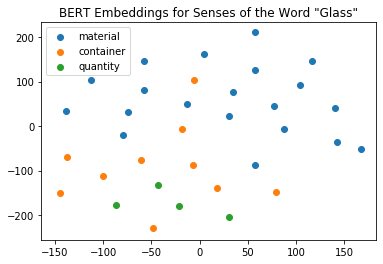

In [208]:
plot_glass_embeddings(summed_embeddings)

In [198]:
final_layer = [take_layer(t, 11) for t in raw_embeddings]

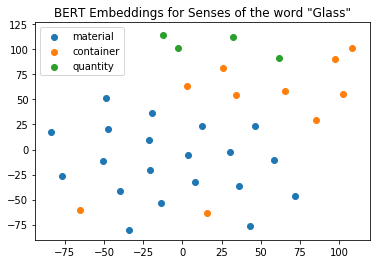

In [203]:
plot_glass_embeddings(final_layer)